# 2차 테스트
* 학습 대상 : test_2.csv(약 1600개) --> 상세 설명은 해당 셀 참조
* 채점 대상 : unfamiliar.csv(84개) --> onion-share-link에서 긁어온 html데이터

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import *
from tensorflow.keras.layers import *

In [ ]:
df = pd.read_csv('test_2.csv')   # WinSCP에서 로드한 폴더 데이터(onion경로에 대해서 중복제거 X)
df.head()

,html,label
0,All BTC .:. Everything you needed ...,0.0
1,Index of /torbrowser/update_2/alpha_old I...,0.0
2,Clone Cards - clone credit cards buy ...,0.0
3,Freedom Market - CC Dumps Shop. Buy cr...,0.0
4,BlackMarket Cc - REAL SELLER CARDS | WEST...,0.0


# 전처리

In [ ]:
df['label'] = df['label'].apply(lambda x: int(x))   # 모델링 편의를 위해 int형으로 변경
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1561 entries, 0 to 1560
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   html    1561 non-null   object
 1   label   1561 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.5+ KB


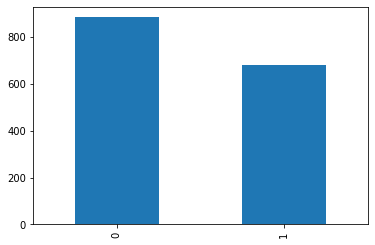

In [ ]:
# 라벨링 분포 확인
df['label'].value_counts().plot(kind='bar')

In [ ]:
# label과 html 분리
input = df['html']
target = df['label']
print('html개수 확인 : ',len(input))
print('label개수 확인 : ',len(target))

html개수 확인 :  1561
label개수 확인 :  1561


In [ ]:
# 불용어 리스트
# 불용어 : 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등은 검색 색인 단어로 의미가 없는 단어이다.
# --> 아래 단어들은 모델 학습에서 제외됨
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))
len(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

179

In [ ]:
# 불용어 단어 추가시
# 현재는 수동으로 긁어왔지만 너무 많은 단어가 Non-english...
# 추후 불용어에 영단어를 제외한 모든글자를 집어넣을수 있는 코드 작성할 것!
stop_words = set(stopwords.words('english'))
new_stop_words = ['ð²','ð¸', '\xa0','ð½ð°', 'ñ\x81', 'ðºð°ð·ð¸ð½ð¾','ñ\x81ð»ð¾ñ\x82ñ\x8b', 'ð´ð°ð»ðµðµ', 'ð¡ðºñ\x80ñ\x8bñ\x82ñ\x8c', 'ð½ðµ', 'ð´ð»ñ\x8f', 'ð¾ð½ð»ð°ð¹ð½', 'ñ\x87ñ\x82ð¾', 'ð´ð¾', 'ð\xa0ðµð³ð¸ñ\x81ñ\x82ñ\x80ð°ñ\x86ð¸ñ\x8f', 'ð¸ð»ð¸', 'ð\xa0ðµð°ðºñ\x86ð¸ð¸', 'ð°', 'ð²ñ\x8b','ð¿ð¾',  'ð¡ð¾ð¾ð±ñ\x89ðµð½ð¸ñ\x8f', 'ð¢ðµð¿ðµñ\x80ñ\x8c', 'ð´ðµð½ñ\x8cð³ð¸', 'ðºð°ðº', 'ð°', 'ð²ñ\x8b', 'ð¿ð¾', 'ð¡ð¾ð¾ð±ñ\x89ðµð½ð¸ñ\x8f', 'ð¢ðµð¿ðµñ\x80ñ\x8c', 'ð´ðµð½ñ\x8cð³ð¸', 'ðºð°ðº', 'ð¼ð¾ð¶ð½ð¾', 'ñ\x8dñ\x82ð¾', 'ð\x94ð»ñ\x8f', '×', 'ð¸ð½ñ\x82ðµñ\x80ð½ðµñ\x82', 'ñ\x87ñ\x82ð¾ð±ñ\x8b', 'ð²ñ\x8bð¸ð³ñ\x80ñ\x8bñ\x88ð°ð¼ð¸', 'ñ\x82ð¾ð»ñ\x8cðºð¾', 'loadingâ\x80¦', 'ð¸ð³ñ\x80ð°ñ\x82ñ\x8c', 'ð·ð°', 'ð¼ð¾ð¶ðµñ\x82ðµ', 'ð\x92ñ\x8b', 'ð¸ð·', 'ð\x9fð¾ð»ñ\x8cð·ð¾ð²ð°ñ\x82ðµð»ñ\x8c', 'ñ\x81ð²ð¾ð¹', 'ð½ð°ñ\x88ðµð¼', 'ð¾ñ\x82', 'ð\x9dð¾ð²ñ\x8bðµ', 'ð½ð¾', 'ð²ð°ð¼', 'ñ\x82ð¾', 'ðº', 'ñ\x83', 'â\x80\x93', 'ñ\x82ð°ðº', 'ð\x9cðµð½ñ\x8e', 'ð¸ð³ñ\x80ñ\x8b', 'ð¿ð¾ð¸ð³ñ\x80ð°ñ\x82ñ\x8c', 'ð²ñ\x81ðµ', 'ñ\x81ñ\x87ðµñ\x82', 'ð\x92', 'ð\x9fñ\x80ð¸ð³ð»ð°ñ\x88ð°ðµð¼', 'ð\x9dð°ð¹ñ\x82ð¸', 'ð¿ñ\x80ð¸', 'â\xa0', 'ñ\x81ñ\x87ðµñ\x82ð°', 'ð¿ñ\x80ð¾ñ\x81ñ\x82ð¾','ð¼ñ\x8b', 'ð±ðµð·', 'ðµñ\x81ð»ð¸', 'ðµñ\x81ñ\x82ñ\x8c', 'ð°ð²ñ\x82ð¾ð¼ð°ñ\x82ñ\x8b', 'ñ\x81ð¾ð¾ð±ñ\x89ðµð½ð¸ñ\x8f', 'ð°ðºñ\x82ð¸ð²ð½ð¾ñ\x81ñ\x82ñ\x8c', 'ñ\x81ð¸ñ\x81ñ\x82ðµð¼ñ\x8b', 'ñ\x87ðµñ\x80ðµð·', 'ñ\x83ð¶ðµ', '©', 'ð\xadñ\x82ð¾', 'ñ\x82ðµð¿ðµñ\x80ñ\x8c', 'ð¸ð³ñ\x80ð¾ð²ð¾ð¹', 'ñ\x81ñ\x82ð°ð²ðºð¸', 'ð½ñ\x83ð¶ð½ð¾', 'ð±ñ\x80ð°ñ\x83ð·ðµñ\x80', 'ð½ð¾ð²ñ\x8bðµ', 'ð\x90ð²ñ\x82ð¾ñ\x80', 'ñ\x8dñ\x82ð¾ð¼', 'ð²ð¾ð·ð¼ð¾ð¶ð½ð¾ñ\x81ñ\x82ñ\x8c', 'ð²ñ\x80ðµð¼ñ\x8f', 'ð\x9dð°ð¶ð¼ð¸ñ\x82ðµ','ð\x9fð¾ð»ñ\x8cð·ð¾ð²ð°ñ\x82ðµð»ð¸',  'ð\x98ð³ñ\x80ð°ð¹ñ\x82ðµ', 'ð±ð¾ð»ñ\x8cñ\x88ðµ', 'ñ\x80ð°ñ\x81ðºñ\x80ñ\x8bñ\x82ñ\x8c', 'ð\x9fð¾ð¸ñ\x81ðº', 'ñ\x8dñ\x82ð¾ð³ð¾', 'ð²ð°ñ\x81', 'ð¾', 'ñ\x8f', 'ð£ñ\x81ñ\x82ð°ð½ð¾ð²ð¸ñ\x82ñ\x8c', 'ð\x92ñ\x85ð¾ð´', 'ð\x95ñ\x81ð»ð¸', 'ð\x9dðµð´ð°ð²ð½ñ\x8fñ\x8f', 'ð¿ñ\x80ð¾ñ\x84ð¸ð»ðµ', 'ð¿ð¾ð¼ð¾ñ\x89ñ\x8cñ\x8e', 'ð¯ð½ð´ðµðºñ\x81', 'ð¡ðµð¹ñ\x87ð°ñ\x81', 'ð±ñ\x83ð´ðµñ\x82', 'searchâ\x80¦', 'xenforo®', 'ð\x97ð°ð³ñ\x80ñ\x83ð·ðºð°', 'ð\x92ñ\x8bð±ð¾ñ\x80', 'ð¸ñ\x81ð¿ð¾ð»ñ\x8cð·ð¾ð²ð°ñ\x82ñ\x8c', 'ð¼ð¾ð¶ðµñ\x82', 'ð\x96ðµð»ð°ðµð¼', 'ð\x9cñ\x8b', 'ðµñ\x89ðµ', 'ñ\x81ðºð°ð·ð°ð»', 'ñ\x82ðµð¼ñ\x8b', 'ð\x98', 'ð¿ð¾ð¿ð¾ð»ð½ñ\x8fñ\x82ñ\x8c', 'ð½ð°ñ\x88ðµð³ð¾', 'ð¼ð¾ð³ñ\x83ñ\x82', 'ðµð³ð¾', 'ð¶ðµ', 'ð¿ð»ð°ñ\x82ðµð¶ð¸', 'ñ\x84ð¾ñ\x80ñ\x83ð¼ðµ', 'ð\x90', 'ñ\x83ð´ð°ñ\x87ð¸', 'ð\xadñ\x82ð¾ñ\x82', 'ñ\x81ð¾', 'ð¿ð¾ð»ñ\x8cð·ð¾ð²ð°ñ\x82ðµð»ð¸', 'ð´ñ\x80ñ\x83ð³ð¸ðµ', 'ð\x9cð¾ð´ðµñ\x80ð°ñ\x82ð¾ñ\x80ñ\x8b', 'ð\x97ð°ñ\x80ðµð³ð¸ñ\x81ñ\x82ñ\x80ð¸ñ\x80ð¾ð²ð°ð½ð½ñ\x8bðµ', 'ðºð¾ñ\x88ðµð»ðµðº', 'ð§ñ\x82ð¾', 'ð²ñ\x8bð¸ð³ñ\x80ñ\x8bñ\x88', 'ñ\x81ñ\x8bð³ñ\x80ð°ñ\x82ñ\x8c', 'ð¡ð»ð¾ñ\x82ñ\x8b', 'ð¸ð³ñ\x80ð¾ð²ñ\x8bðµ', 'ð²ðµð±', 'ñ\x82ð°ðºð¶ðµ', 'ð\x9að°ðº', 'â\x80\x94', "'", 'ðºð¾ñ\x82ð¾ñ\x80ñ\x8bð¹', 'ð\x94ðµð½ñ\x8cð³ð¸', 'ð¾ð½', 'ðºð¾ñ\x88ðµð»ñ\x8cðºð°', 'ñ\x80ñ\x83ð»ðµñ\x82ðºñ\x83', 'ð\xa0ñ\x83ñ\x81ñ\x81ðºð¸ð¹', 'ñ\x81ð¿ð¾ñ\x81ð¾ð±', 'ñ\x81ð»ð¾ñ\x82ð°ñ\x85', 'ð¿ð»ð°ñ\x82ðµð¶ð½ð¾ð¹', 'ð\x9dðµ', 'ñ\x8dñ\x82ð¾ð¹', 'ð½ðµñ\x82', 'ð¸ð³ñ\x80', 'ð´ðµð»ð°ñ\x82ñ\x8c', 'ð½ð¾ð²ð¾ð³ð¾', 'ð²ñ\x8bð¸ð³ñ\x80ñ\x8bñ\x88ð¸', 'ñ\x81ð°ð¹ñ\x82ð°', 'ð¿ð¾ð¿ñ\x80ð¾ð±ð¾ð²ð°ñ\x82ñ\x8c', 'ð¸ñ\x85', 'ñ\x81ð¸ñ\x81ñ\x82ðµð¼ñ\x83', 'ðºñ\x82ð¾', 'ð´ñ\x80ñ\x83ð³ð¾ð¹', 'ñ\x80ð°ð·', 'ð½ð¾ð²ð°ñ\x8f', 'ñ\x81ðµð¹ñ\x87ð°ñ\x81', 'ð¼ð¸ñ\x80', 'ð¸ð³ñ\x80ð¾ðºð¾ð²', 'ð¿ð¾ñ\x81ð»ðµ', 'ð´ðµð¿ð¾ð·ð¸ñ\x82ð°', 'ñ\x81ð°ð¹ñ\x82ñ\x8b', 'ð½ðµð¼', 'ð²ñ\x81ðµð³ð¾', 'ð²ñ\x81ðµñ\x85', 'ð¿ð¾ð¶ð°ð»ñ\x83ð¹ñ\x81ñ\x82ð°', 'ð¸ñ\x81ð¿ð¾ð»ñ\x8cð·ð¾ð²ð°ð½ð¸ñ\x8f', 'ñ\x82ñ\x8b', 'ð\x97ð°ðºñ\x80ñ\x8bñ\x82ñ\x8c', 'ð¿ð¾ð¼ð¾ñ\x89ð¸', 'ð\x92ð°ñ\x88ð°', 'ð³ð´ðµ', 'ð¿ð¾ð¸ñ\x81ðº', 'ð²ñ\x8bð²ð¾ð´ð¸ñ\x82ñ\x8c', 'ð¾ð±ð½ð¾ð²ð¸ñ\x82ñ\x8c', 'ðºð¾ñ\x82ð¾ñ\x80ð°ñ\x8f', 'ð±ð°ð»ð°ð½ñ\x81', 'ð¿ñ\x80ð¸ð»ð¾ð¶ðµð½ð¸ðµ', 'ð¿ð¾ð¿ð¾ð»ð½ðµð½ð¸ñ\x8f', 'ð¿ð¾ðºðµñ\x80', 'ð¿ð¾ð±ðµð´ð¸ñ\x82ðµð»ñ\x8f', 'ð¿ð°ñ\x80ð°ð¼ðµñ\x82ñ\x80ñ\x8b', 'ð´ð¸ñ\x81ðº', 'ñ\x81ð²ð¾ñ\x91ð¼', 'ñ\x87ðµð¼', 'ð¸ñ\x81ð¿ð¾ð»ñ\x8cð·ñ\x83ðµñ\x82ðµ', 'ð±ñ\x80ð°ñ\x83ð·ðµñ\x80ðµ', 'ñ\x80ðµðºð»ð°ð¼ð°', 'ñ\x80ðµðºð»ð°ð¼ñ\x83', 'ð\x94ð¾ð¿ð¾ð»ð½ð¸ñ\x82ðµð»ñ\x8cð½ñ\x8bðµ', 'ð½ðµð¿ñ\x80ð°ð²ð¸ð»ñ\x8cð½ð¾', 'ð¡ð¾ð·ð´ð°ñ\x82ñ\x8c', 'ð\x9fð¾ð¼ð¾ñ\x89ñ\x8c', 'ð\xa0ðµðºð»ð°ð¼ð°', 'ð\x93ð»ð°ð²ð½ð°ñ\x8f', 'ñ\x81ð´ðµð»ð°ñ\x82ñ\x8c', 'ð\x9bðµð½ñ\x82ð°', 'ð\x98ñ\x81ðºð°ñ\x82ñ\x8c', 'ð\xa0ð°ñ\x81ñ\x88ð¸ñ\x80ðµð½ð½ñ\x8bð¹', 'ñ\x83ñ\x81ñ\x82ð°ñ\x80ðµð²ñ\x88ð¸ð¹', 'ð¾ñ\x82ð¾ð±ñ\x80ð°ð¶ð°ñ\x82ñ\x8cñ\x81ñ\x8f', 'ð\x9dðµð¾ð±ñ\x85ð¾ð´ð¸ð¼ð¾', 'ð\x92ð°ñ\x88ð¸', 'ð·ð°ð³ð¾ð»ð¾ð²ðºð°ñ\x85', 'ð\x9dð°ð²ð¸ð³ð°ñ\x86ð¸ñ\x8f', 'ð¾ñ\x82ðºð»ñ\x8eñ\x87ñ\x91ð½', 'ð¿ð¾ð»ð½ð¾ñ\x86ðµð½ð½ð¾', 'ð²ðºð»ñ\x8eñ\x87ð¸ñ\x82ðµ', 'ñ\x81ñ\x82ð¸ð»ñ\x8f', 'ð\x92ðµñ\x80ñ\x85', 'ñ\x81ð²ð¾ð¸', 'ð´ðµð¿ð¾ð·ð¸ñ\x82', 'ðºð¾ñ\x82ð¾ñ\x80ñ\x8bðµ', 'ñ\x81ñ\x82ð°ñ\x82ñ\x8c', 'ð²ñ\x81ðµð³ð´ð°', 'ð¸ð³ñ\x80ð°', 'ñ\x82ð¾ð³ð¾', 'ð±ðµñ\x81ð¿ð»ð°ñ\x82ð½ñ\x8bðµ', 'ð²ñ\x8bð¸ð³ñ\x80ð°ñ\x82ñ\x8c', 'ð±ð¸ñ\x80ð¶ðµ', 'ð\x94ð¾ð±ð°ð²ð»ðµð½ñ\x8b','ð¼ð½ð¾ð³ð¾', 'ð±ñ\x8b', 'ðºð°ð·ð¸ð½ð½ñ\x8bðµ', 'ð\x92ð°ñ\x88', 'ð´ðµð¿ð¾ð·ð¸ñ\x82ñ\x8b', 'ð¡', 'ðºð¾ð½ñ\x82ðµð½ñ\x82', 'ð¿ñ\x80ð¾', 'ðºð¾ð´', 'ð´ñ\x80ñ\x83ð³ð¸ñ\x85', 'ñ\x81ñ\x82ñ\x80ð°ð½ð¸ñ\x86ðµ', 'ð¿ð¾ð»ñ\x83ñ\x87ð¸ñ\x82ñ\x8c', 'ð¼ðµñ\x81ñ\x82ð¾', 'ð²ñ\x8bð±ñ\x80ð°ñ\x82ñ\x8c', 'ðµðµ', 'ð±ñ\x8bñ\x82ñ\x8c', 'ñ\x81ñ\x80ðµð´ñ\x81ñ\x82ð²ð°', 'ñ\x80ðµð³ð¸ñ\x81ñ\x82ñ\x80ð°ñ\x86ð¸ð¸', 'ñ\x81ñ\x82ð°ñ\x82ðµð¹', 'ðºñ\x80ð¸ð¿ñ\x82ð¾', 'ð½ð¸', 'ð´ð°', 'ð\x92ð½ð¸ð¼ð°ð½ð¸ðµ', 'ð¸ð³ñ\x80ñ\x83', 'ð\x9að¾ð½ðºñ\x83ñ\x80ñ\x81ð°', 'ñ\x81ñ\x82ð°ð²ðºð°', 'ñ\x83ñ\x87ð°ñ\x81ñ\x82ð½ð¸ðºð¾ð²', 'ð\x9fñ\x80ð¾ð³ð¾ð»ð¾ñ\x81ñ\x83ð¹ñ\x82ðµ', 'ð¿ð¾ð´ð´ðµñ\x80ð¶ð¸ñ\x82ðµ', 'ð¿ñ\x80ð¾ð±ð»ðµð¼ñ\x8b', 'ð¾ñ\x87ðµð½ñ\x8c', 'ñ\x81ð¸ñ\x81ñ\x82ðµð¼ð°', 'ñ\x81ð°ð¼ð¾ðµ', 'ð½ð°ð´ð¾', 'ð²ñ\x8bñ\x88ðµ', 'ð´ð°ð¶ðµ', 'ð±ð¾ð»ðµðµ', 'ð±ñ\x83ñ\x84ðµñ\x80', 'ñ\x82ðµñ\x85', 'ð½ð°ñ\x81', 'ð¾ð¿ñ\x86ð¸ð¸', 'ð´ð¾ñ\x85ð¾ð´', 'ð\xadñ\x82ð°', 'ñ\x88ð°ð½ñ\x81', 'ð¾ð±ð¼ðµð½ð°', 'ð²ñ\x8bð²ð¾ð´ð°', 'ð²ð¾', 'ð¿ñ\x80ð¸ð½ð¸ð¼ð°ðµð¼','ð³ð¾ð´ð°',  'ð¢ð°ðº', 'ð½ð°ñ\x81ñ\x82ð¾ñ\x8fñ\x89ð¸ðµ', 'ñ\x80ðµð°ð»ñ\x8cð½ñ\x8bðµ', 'ð¿ð¾ð¿ð¾ð»ð½ð¸ñ\x82ñ\x8c', 'ð¸ð³ñ\x80ð¾ðºð°ð¼', 'ð»ð¸', 'ð¿ñ\x80ð¸ð½ð¸ð¼ð°ñ\x8eñ\x82ñ\x81ñ\x8f', 'ð¼ð°ñ\x8f', 'ñ\x81ñ\x82ð°ð²ðºñ\x83', 'ð±ð°ð»ð°ð½ñ\x81ð°', 'ðºñ\x83ñ\x88', 'ð°ð²ñ\x82ð¾ð¼ð°ñ\x82', 'ð¡ðºð¾ð¿ð¸ñ\x80ð¾ð²ð°ñ\x82ñ\x8c', 'ð¸ð³ñ\x80ð°ñ\x8f', 'ð²ñ\x8bð¸ð³ñ\x80ñ\x8bñ\x88ð°', '·', 'ð½ð°ñ\x87ð°ñ\x82ñ\x8c', 'ñ\x83ðºð°ð·ð°ñ\x82ñ\x8c', 'ð¿ñ\x80ð¾ñ\x82ð¸ð²', 'ð²ð½ð¸ð¼ð°ð½ð¸ðµ', 'ñ\x81ñ\x81ñ\x8bð»ðºñ\x83', 'ð·ð°ñ\x82ðµð¼', 'ã\xa0', 'ð¾ð´ð½ð¾ð³ð¾', 'ð\x9fñ\x80ð¸', 'ð¼ð¾ð¼ðµð½ñ\x82', 'ñ\x82ð¾ð¼', 'ñ\x84ð°ð¹ð»', 'ð´ð¾ñ\x81ñ\x82ñ\x83ð¿ð½ð°', 'ð¿ð¾ðºð°', 'ð¾ð´ð¸ð½', 'ñ\x81ð¸ñ\x81ñ\x82ðµð¼ðµ', 'ð¿ð¾ð»ñ\x8cð·ð¾ð²ð°ñ\x82ðµð»ðµð¹', 'ñ\x81ð²ñ\x8fð·ð¸', 'ð¿ð¾ð²ðµð·ðµñ\x82', 'ð´ð°ð½ð½ñ\x8bñ\x85', 'ð´ð°ð½ð½ñ\x8bð¹', 'ð±ñ\x83ð´ñ\x83ñ\x82', 'ð\x9fð¾ñ\x81ð»ðµð´ð½ñ\x8fñ\x8f', 'ð¿ñ\x80ð¾ñ\x89ðµ', 'ð¿ð¾ð¿ð¾ð»ð½ðµð½ð¸ðµ', 'ñ\x83ð´ð°ñ\x87ñ\x83', 'ð²ð°ð»ñ\x8eñ\x82ð°', 'ð¿ð»ð°ñ\x82ðµð¶ð½ñ\x83ñ\x8e', 'ð¸ð³ñ\x80ðµ', 'ð¿ñ\x80ð¸ñ\x83ð¼ð½ð¾ð¶ð¸ñ\x82ñ\x8c', 'ð²ñ\x8bð¸ð³ñ\x80ñ\x8bñ\x88ðµð¹', 'ð\x91ð¸ð»ð°ð¹ð½', 'ð\x9cðµð³ð°ñ\x84ð¾ð½', 'ð¿ð¾ð±ðµð´ð¸ñ\x82ðµð»ðµð¹', 'ð¿ñ\x80ð¸ð·', 'ñ\x82ñ\x83ñ\x80ð½ð¸ñ\x80ð°', 'ñ\x81ð¼ðµð½ð°', 'ð\x9fð¾ð¿ñ\x80ð¾ð±ñ\x83ð¹ñ\x82ðµ', 'ð\x97ð¾ð´ð¸ð°ðºð°', 'ð\x9fð»ð°ð½ð¾ð²ð°ñ\x8f', 'ð¿ð°ñ\x80ð¾ð»ðµð¹ð\x92ð¾ð·ð½ð¸ðºð»ð¸', 'ð±ñ\x8bð»', 'ð¯', 'ð´ðµð½ðµð³', 'ñ\x8dñ\x82ð¾ñ\x82', 'ñ\x82ðµð»ðµñ\x84ð¾ð½ð°', 'ð¿ð¾ñ\x8dñ\x82ð¾ð¼ñ\x83', '–', 'ñ\x80ð°ð·ð´ðµð»', 'ð²ð¾ð¹ñ\x82ð¸', 'ðºð¾ð³ð´ð°', 'ñ\x81ð½ð¾ð²ð°', 'ð\x9eñ\x82ð²ðµñ\x82ñ\x8b', 'ñ\x82ðµð¼ð°', 'ð²ñ\x8bð²ðµñ\x81ñ\x82ð¸', 'ñ\x8dñ\x82ð¸ñ\x85', 'ð¾ð±ð¾ð¹ñ\x82ð¸', 'ñ\x81ð°ð¼ñ\x8bñ\x85', 'ñ\x81ñ\x80ðµð´ñ\x81ñ\x82ð²', 'ð´ð¾ñ\x81ñ\x82ð°ñ\x82ð¾ñ\x87ð½ð¾', 'ñ\x81ñ\x83ð¼ð¼ñ\x83', 'ð½ð°ñ\x88ð¸ñ\x85', 'ñ\x82ð°ð¼', 'ð¿ð¾ð»ñ\x83ñ\x87ð¸ñ\x82ðµ', 'ñ\x82', 'ð²ð¾ð·ð¼ð¾ð¶ð½ð¾', 'ðºñ\x80ð¸ð¿ñ\x82ð¾ð²ð°ð»ñ\x8eñ\x82', 'ñ\x82ð¾ð¶ðµ', 'ð½ð°ð¿ñ\x80ð¸ð¼ðµñ\x80', 'ð½ð°ñ\x88ñ\x83', 'ñ\x82ðµñ\x80ð¼ð¸ð½ð°ð»ñ\x8b', 'ð\x92ðºð¾ð½ñ\x82ð°ðºñ\x82ðµ', 'ð\x9fð¾ð¶ð°ð»ñ\x83ð¹ñ\x81ñ\x82ð°', 'ð½ð°ð·ð°ð´', 'ð\x9fð¾', 'ð\x97ð¾ð»ð¾ñ\x82ð¾ð¹', 'ð²ð½ðµñ\x81ðµð½ð¸ñ\x8f', 'ð²ñ\x8bð¿ð»ð°ñ\x82ñ\x8b', 'ð±ð»ð¾ðºð¸ñ\x80ð¾ð²ðºñ\x83', 'ð·ð¾ð¼ð±ð¸','ð\x97ð°ñ\x80ð°ð±ð°ñ\x82ñ\x8bð²ð°ð¹',  'ð½ð¸ñ\x85', 'ñ\x83ð´ð°ñ\x87ð°', 'ð²ð°ð»ñ\x8eñ\x82ñ\x83', 'ñ\x80ðµñ\x82ñ\x80ð¾', 'ñ\x81ð»ð¾ñ\x82ð¾ð²', 'ð¼ð¾ð±ð¸ð»ñ\x8cð½ð¾ð³ð¾', 'ð\x9að¾ñ\x80ð¾ð»ðµð²ð°', 'ð\x9fñ\x83ñ\x81ñ\x82ñ\x8bð½ð¸', 'ð\x9cñ\x83ð»ðµð½', 'ð\xa0ñ\x83ð¶', 'ð\x94ð²ð¾ð¹ð½ð¾ð¹', 'ð\x90ð»ð¼ð°ð·', 'ð\x94ð¾ð±ð°ð²ð»ðµð½ð°', 'ñ\x82ñ\x83ñ\x80ð½ð¸ñ\x80', 'ð½ð¾ñ\x8fð±ñ\x80ñ\x8f', 'ð±ð»ñ\x8dðºð´ð¶ðµðº', 'ð¼ð¾ð±ð¸ð»ñ\x8cð½ð¾ð¼', 'ð\x9cð¢ð¡', 'ð\x9fð¾ð´ð²ð¾ð´ð½ñ\x8bð¹', 'ð\x93ð¾ð½ð¾ñ\x87ð½ñ\x8bðµ', 'ð\x9cð°ð³ð¸ñ\x87ðµñ\x81ðºð¸ð¹', 'ñ\x81ñ\x87ñ\x91ñ\x82ð°', 'ð\x9fñ\x80ð¸ð½ð¾ñ\x81ð¸ð¼', 'ð¸ð·ð²ð¸ð½ðµð½ð¸ñ\x8f', 'ð½ðµñ\x83ð´ð¾ð±ñ\x81ñ\x82ð²ð¾', 'ð¾ð´ð½ð¾ð¹', 'ð·ð´ðµñ\x81ñ\x8c', 'ñ\x8dñ\x82ð¸', 'ð¾ð±ñ\x80ð°ñ\x82ð¸ñ\x82ðµ', 'ð½ðµñ\x81ðºð¾ð»ñ\x8cðºð¾', 'ñ\x81ñ\x80ð°ð·ñ\x83', 'ð²ðµñ\x80ñ\x81ð¸ð¸', 'ð¼ð½ðµ', 'ð²ñ\x81ðµð¼', 'ð·ð°ñ\x80ðµð³ð¸ñ\x81ñ\x82ñ\x80ð¸ñ\x80ð¾ð²ð°ñ\x82ñ\x8cñ\x81ñ\x8f', 'ð´ñ\x80ñ\x83ð³ð¸ð¼ð¸', 'ð§ñ\x82ð¾ð±ñ\x8b', 'ñ\x82ð°ðºð¸ñ\x85', 'ñ\x81ñ\x82ð¾ð¸ñ\x82', 'itâ\x80\x99s', 'ñ\x82ñ\x83ñ\x82', 'ñ\x80ð°ð´ð¸', 'ð±ð»ð¾ðºð¸ñ\x80ð¾ð²ðºð¸', 'ñ\x80ð°ð·ð°', 'ð½ð°ñ\x87ð°ð»ð°',  'ð¸ñ\x81ð¿ð¾ð»ñ\x8cð·ñ\x83ñ\x8f', 'ñ\x81ð²ð¾ðµð¼', 'ð\x9að¾ð´', 'navigateurâ\xa0tor', 'ð²ðµñ\x81ñ\x8c', 'ð¼ð°ñ\x81ñ\x81ð¸ð²', 'ð¾ð±ñ\x80ð°ñ\x82ð½ð¾', 'ð¾ð¿ð»ð°ñ\x82ñ\x8b', 'ð½ð¾ð²ð¾ð¹', 'espaã±ol', 'ð½ðµð¼ð½ð¾ð³ð¾', 'ð¿ð¾ñ\x80ð°', 'ñ\x80ð°ð·ð¼ðµñ\x80ðµ', 'ñ\x82ðµð¼', 'ñ\x82ð¾ð³ð´ð°', 'ð¾ð¿ñ\x86ð¸ñ\x8f', 'ð¿ð¾ñ\x81ñ\x80ðµð´ñ\x81ñ\x82ð²ð¾ð¼', 'ð¸ð½ñ\x82ðµñ\x80ðµñ\x81', 'ð²ð¾ñ\x82', 'ñ\x80ð°ñ\x81ñ\x81ñ\x8bð»ðºñ\x83', 'ð½ð¾ð²ð¾ñ\x81ñ\x82ñ\x8c', 'ð²ð¾ð·ð¼ð¾ð¶ð½ð¾ñ\x81ñ\x82ñ\x8cñ\x8e', 'ð¾ñ\x82ð²ðµñ\x82ð°', 'ñ\x81ñ\x87ñ\x91ñ\x82', 'ð½ð¾ð²ðµð¹ñ\x88ð¸ð¹', 'portuguãªs', 'ð²ðµñ\x80ñ\x81ð¸ñ\x8f', 'ñ\x83ñ\x81ðºð¾ñ\x80ð¸ñ\x82ñ\x8c', 'ð¿ðµñ\x80ðµð²ð¾ð´ñ\x8b', 'ñ\x83ñ\x81ð¿ðµñ\x88ð½ñ\x8bð¼', 'ð½ð¾ð²ð¾ñ\x81ñ\x82ðµð¹', 'ð\x9eð´ð½ð¾ðºð»ð°ñ\x81ñ\x81ð½ð¸ðºð¸', 'ð¢ðµð¼ñ\x8b', 'ð\x92ð¿ðµñ\x80ñ\x91ð´', 'ð¼ðµð½ñ\x8f', 'ð±ñ\x8bð»ð¾', 'ð¿ð¾ð´ñ\x82ð²ðµñ\x80ð¶ð´ðµð½ð¸ñ\x8f', 'ð¾ð±ð¾ð³ð°ñ\x89ðµð½ð¸ðµ', 'ð¿ð¾ð¿ð¾ð»ð½ð¸ð»ñ\x81ñ\x8f', 'ñ\x80ñ\x83ð»ðµñ\x82ðºð¸', 'ñ\x81ð¿ñ\x80ð°ð²ð¾ðº', 'ð¿ð¾ñ\x80ñ\x83ñ\x87ð¸ñ\x82ðµð»ðµð¹', 'ð·ð°ñ\x87ð¸ñ\x81ð»ðµð½ð¸ðµ', 'ð»ð°ð¹ñ\x82ðºð¾ð¸ð½', 'ð¢ðµð»ðµ2', 'ð²ñ\x8bð¸ð³ñ\x80ð°ð¹ñ\x82ðµ', 'ð¡ñ\x87ð°ñ\x81ñ\x82ð»ð¸ð²ð¾ð³ð¾', 'ñ\x81ð»ð¾ñ\x82ð°ð¼', 'ð¸ð³ñ\x80ð¾ðºð¸', 'ð¾ð±ñ\x8añ\x8fð²ð»ñ\x8fðµð¼', 'ð¸ð¼ðµð½ð½ð¾', 'ð¤ð¸ð½ð°ð½ñ\x81ñ\x8b', 'ð¿ð¾ð¿ñ\x8bñ\x82ð°ñ\x82ñ\x8c', 'ð»ð¾ñ\x82ðµñ\x80ðµñ\x8f', 'ñ\x81ð¿ð¸ñ\x81ð¾ðº', 'ð\x9dñ\x83', 'ð°ð´ñ\x80ðµñ\x81','ð½ð¾ð²ñ\x8bð¹','ð\x9a','ð\x98ð½ñ\x84ð¾ñ\x80ð¼ð°ñ\x86ð¸ñ\x8f','ñ\x82ð°ðºð¾ð¹']
stop_words.update(new_stop_words)
print('불용어 단어 개수 : ',len(stop_words))

불용어 단어 개수 :  661


In [ ]:
# 불용어 제거한 토큰(단어) 리스트 만들기
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import text_to_word_sequence
result = []   # 빈 리스트
for num in range(1561):
  word_tokens = text_to_word_sequence(input[num])   # 각 html안의 모든 문장을 단어별로 쪼개줌
  each_list = []            # 각 html별 list
  for w in word_tokens:
    if w not in stop_words:    # 불용어 체크한 뒤 불용어 아닌 단어들만 each_list에 포함
      each_list.append(w)
  result.append(each_list)     # 각각의 each_list를 result안에 집어넣음
print(result)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
tokenizer = Tokenizer()   # https://wikidocs.net/31766 --> keras의 텍스트 전처리 부분 리뷰하기
tokenizer.fit_on_texts(result)
sequences = tokenizer.texts_to_sequences(result)  # 쪼개진 단어들에 번호 부여
print(sequences[:5])

[[72, 600, 1141, 5579, 1845, 8007, 1807, 5579, 351, 8008, 8009, 468, 1915, 169, 904, 2826, 678, 2, 38, 110, 2758, 1787, 2, 38, 29, 3763, 3282, 2, 38, 77, 72, 6227, 351, 647, 22, 18, 165, 8010, 112, 647, 22, 29, 79, 904, 2826, 678, 2, 62, 41, 5, 80, 1845, 647, 2, 62, 110, 590, 117, 28, 2, 37, 38, 8011, 8012, 7137, 2, 41, 77, 442, 1807, 647, 216, 2, 41, 110, 5, 80, 1845, 647, 2, 18, 127, 3630, 351, 647, 2, 18, 128, 1, 765, 481, 115, 1981, 1845, 398, 8, 48, 1684, 2019, 481, 61, 57, 87, 1182, 686, 104, 176, 678, 25, 112, 166, 4978, 481, 111, 494, 26, 57, 414, 8, 321, 112, 3071, 104, 5317, 111, 63, 48, 32, 36, 61, 80, 481, 543, 481, 359, 57, 1, 481, 506, 351, 527, 401, 5826, 2130, 34, 481, 61, 3558, 28, 658, 2176, 98, 596, 28, 1826, 107, 481, 679, 101, 57, 606, 2, 38, 88, 289, 245, 221, 367, 8013, 8014, 8015, 1216, 58, 2177, 61, 1239, 245, 221, 618, 652, 8016, 8017, 1216, 58, 721, 61, 1239, 245, 221, 618, 652, 7676, 8018, 1216, 58, 721, 61, 1239, 245, 221, 618, 652, 7677, 8019, 818, 58, 355

In [ ]:
word_to_index = tokenizer.word_index    # 어떤 단어가 어떤 숫자에 배정받았는지 키:값 형태 list출력 --> 숫자가 낮을수록 빈도수 多
word_to_index

{'1': 1,
 '2021': 2,
 'type': 3,
 'search': 4,
 'new': 5,
 'zooville': 6,
 'description': 7,
 '2': 8,
 '0': 9,
 '5': 10,
 '10': 11,
 'cards': 12,
 'browser': 13,
 'card': 14,
 'tor': 15,
 'false': 16,
 'required': 17,
 '07': 18,
 '00': 19,
 'porn': 20,
 '21': 21,
 '2020': 22,
 '01': 23,
 'free': 24,
 '3': 25,
 'get': 26,
 '02': 27,
 'us': 28,
 '11': 29,
 'javascript': 30,
 'find': 31,
 'view': 32,
 '12': 33,
 'use': 34,
 'buy': 35,
 '4': 36,
 '05': 37,
 '08': 38,
 'string': 39,
 'latest': 40,
 '06': 41,
 'forums': 42,
 'posts': 43,
 'time': 44,
 'money': 45,
 '000x': 46,
 'log': 47,
 'click': 48,
 'members': 49,
 'date': 50,
 'register': 51,
 'community': 52,
 '20': 53,
 'default': 54,
 'resources': 55,
 'menu': 56,
 'order': 57,
 'com': 58,
 '2019': 59,
 'reactions': 60,
 'transfer': 61,
 '04': 62,
 'like': 63,
 '100': 64,
 'id': 65,
 '15': 66,
 'video': 67,
 'may': 68,
 "what's": 69,
 'using': 70,
 'child': 71,
 'btc': 72,
 'cvv': 73,
 'sex': 74,
 'account': 75,
 'current': 76,
 '03'

In [ ]:
limit = 2
total_count = len(word_to_index)  # 총 단어의 수
rare_count = 0   # limit보다 등장 빈도수가 적은 단어 개수를 count
total_freq = 0  # 훈련데이터 전체 단어빈도수 총합
rare_freq = 0  # 등장빈도수가 limit보다 적은 단어의 등장 빈도수총합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if value < limit : 
        rare_count = rare_count + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(limit - 1, rare_count))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_count / total_count)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 31276
단어 집합(vocabulary)에서 희귀 단어의 비율: 46.13864015224158
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.2066240429135617


In [ ]:
vocab_size = len(word_to_index) + 1   # 단어의 개수
                                      # +1을 해준 이유는 word_to_index가 0번부터 임베딩되기 때문이다
print('단어집합 크기 : ',vocab_size)

단어집합 크기 :  700


In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(sequences,target,test_size=0.2,random_state=42,
                                                 stratify=target)

html 최대 길이 :  43533
html 평균 길이 :  307.2011531069827


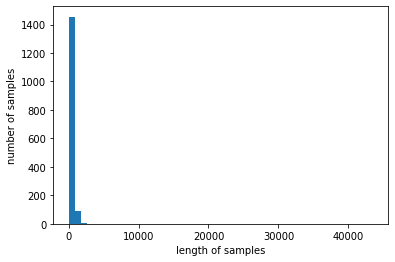

In [ ]:
# html 길이 통계
print('html 최대 길이 : ',max(len(l) for l in sequences))
print('html 평균 길이 : ',(sum(map(len,sequences)))/len(sequences))
plt.hist([len(s) for s in sequences],bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# html을 max_len 길이까지만 분석 --> 나머지 데이터는 전부 0으로 변환(해석에 영향X)
max_len = 1000
train_seq = pad_sequences(X_train,maxlen=max_len)
test_seq = pad_sequences(X_test,maxlen=max_len)

# Embedding(RNN)모델 사용

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32,input_length=1000)) # 임베딩 벡터의 차원은 32 
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# 옵션 설정1(테스트용으로 남겨둠)
rms_prop = optimizers.RMSprop(learning_rate=1e-4)
cp = callbacks.ModelCheckpoint('best-embedding-model.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model.compile(optimizer=rms_prop, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[cp,es])

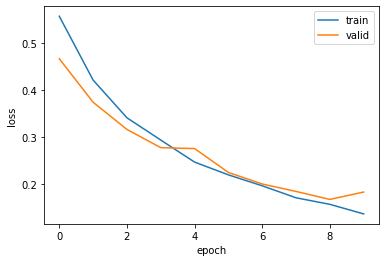

In [ ]:
# loss와 val_loss 값 비교
# 모델 과적합 체크
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()

In [ ]:
embedding_model = models.load_model('best-embedding-model.h5')
embedding_model.evaluate(test_seq,y_test)

10/10 [==============================] - 1s 46ms/step - loss: 0.2304 - acc: 0.9425


[0.23042604327201843, 0.9424920082092285]

In [ ]:
embedding_model.predict(test_seq)

In [ ]:
'''
cp = callbacks.ModelCheckpoint('best-embedding-model2.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
history_2 = model.fit(train_seq,y_train,epochs=5,batch_size=32,validation_split=0.2,callbacks=[cp,es])
'''

In [ ]:
'''
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()
'''

In [ ]:
'''
embedding_model = models.load_model('best-embedding-model2.h5')
embedding_model.evaluate(test_seq,y_test)
'''

In [ ]:
'''
embedding_model.predict(test_seq)
'''

# LSTM모델 사용

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size,32,input_length=1000))
model2.add(LSTM(32,dropout=0.4))
model2.add(Dense(1,activation='sigmoid'))

In [ ]:
rms_prop = optimizers.RMSprop(learning_rate=1e-4)
cp = callbacks.ModelCheckpoint('best-lstm-model.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model2.compile(optimizer=rms_prop, loss='binary_crossentropy', metrics=['acc'])
history = model2.fit(train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[cp,es])

Epoch 1/10
32/32 [==============================] - 17s 468ms/step - loss: 0.6879 - acc: 0.7786 - val_loss: 0.6835 - val_acc: 1.0000
Epoch 2/10
32/32 [==============================] - 15s 460ms/step - loss: 0.6787 - acc: 0.9519 - val_loss: 0.6733 - val_acc: 1.0000
Epoch 3/10
32/32 [==============================] - 14s 450ms/step - loss: 0.6665 - acc: 0.9830 - val_loss: 0.6593 - val_acc: 1.0000
Epoch 4/10
32/32 [==============================] - 14s 445ms/step - loss: 0.6500 - acc: 0.9870 - val_loss: 0.6395 - val_acc: 1.0000
Epoch 5/10
32/32 [==============================] - 14s 442ms/step - loss: 0.6260 - acc: 0.9870 - val_loss: 0.6111 - val_acc: 1.0000
Epoch 6/10
32/32 [==============================] - 14s 449ms/step - loss: 0.5920 - acc: 0.9870 - val_loss: 0.5688 - val_acc: 1.0000
Epoch 7/10
32/32 [==============================] - 14s 447ms/step - loss: 0.5365 - acc: 0.9870 - val_loss: 0.4953 - val_acc: 1.0000
Epoch 8/10
32/32 [==============================] - 14s 441ms/step - 

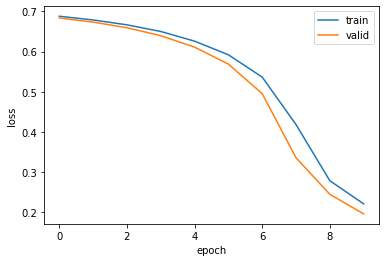

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()

In [ ]:
lstm_model = models.load_model('best-lstm-model.h5')
lstm_model.evaluate(test_seq,y_test)

10/10 [==============================] - 1s 71ms/step - loss: 0.2298 - acc: 0.9840


[0.22975336015224457, 0.9840255379676819]

In [ ]:
lstm_model.predict(test_seq,verbose=0)

In [ ]:
'''
cp = callbacks.ModelCheckpoint('best-lstm-model2.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(train_seq, y_train, epochs=5, batch_size=32, validation_split=0.2,callbacks=[cp,es])
'''

In [ ]:
'''
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()
'''

In [ ]:
'''
lstm_model = models.load_model('best-lstm-model2.h5')
lstm_model.evaluate(test_seq,y_test)
'''

In [ ]:
#lstm_model.predict(test_seq)

# GRU 모델 사용

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size,32,input_length=1000))
model3.add(GRU(32,dropout=0.4))
model3.add(Dense(1,activation='sigmoid'))

In [ ]:
rms_prop = optimizers.RMSprop(learning_rate=1e-4)
cp = callbacks.ModelCheckpoint('best-gru-model.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model3.compile(optimizer=rms_prop, loss='binary_crossentropy', metrics=['acc'])
history = model3.fit(train_seq, y_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[cp,es])

Epoch 1/10
32/32 [==============================] - 18s 491ms/step - loss: 0.6822 - acc: 0.7916 - val_loss: 0.6749 - val_acc: 0.9520
Epoch 2/10
32/32 [==============================] - 15s 475ms/step - loss: 0.6691 - acc: 0.9519 - val_loss: 0.6619 - val_acc: 1.0000
Epoch 3/10
32/32 [==============================] - 15s 468ms/step - loss: 0.6546 - acc: 0.9840 - val_loss: 0.6463 - val_acc: 1.0000
Epoch 4/10
32/32 [==============================] - 15s 476ms/step - loss: 0.6365 - acc: 0.9870 - val_loss: 0.6282 - val_acc: 1.0000
Epoch 5/10
32/32 [==============================] - 15s 474ms/step - loss: 0.6177 - acc: 0.9880 - val_loss: 0.6065 - val_acc: 1.0000
Epoch 6/10
32/32 [==============================] - 15s 477ms/step - loss: 0.5936 - acc: 0.9870 - val_loss: 0.5807 - val_acc: 1.0000
Epoch 7/10
32/32 [==============================] - 15s 470ms/step - loss: 0.5659 - acc: 0.9870 - val_loss: 0.5495 - val_acc: 1.0000
Epoch 8/10
32/32 [==============================] - 15s 470ms/step - 

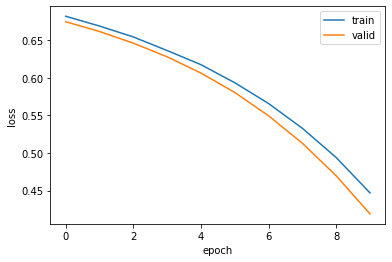

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()

In [ ]:
gru_model = models.load_model('best-gru-model.h5')
gru_model.evaluate(test_seq,y_test)

10/10 [==============================] - 1s 65ms/step - loss: 0.4332 - acc: 0.9712


[0.4332277774810791, 0.9712460041046143]

In [ ]:
gru_model.predict(test_seq)

In [ ]:
'''
cp = callbacks.ModelCheckpoint('best-gru-model2.h5')
es = callbacks.EarlyStopping(patience=3,restore_best_weights=True)
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = model3.fit(train_seq, y_train, epochs=5, batch_size=32, validation_split=0.2,callbacks=[cp,es])
'''

In [ ]:
'''
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.show()
'''

In [ ]:
'''
gru_model = models.load_model('best-gru-model2.h5')
gru_model.evaluate(test_seq,y_test)
'''

In [ ]:
# gru_model.predict(test_seq)

# onion-share 데이터로 채점

In [ ]:
score = pd.read_csv('unfamiliar.csv')
score.head()

,html,label,path
0,Best Financial Service - #1 shop to ear...,0,222222222xn2ozdb2mjnkjrvcopf5thb6la6yj24jvyjqr...
1,"bitcoin, bitcoin generator, free bitcoin ...",0,22222uswoye6ve7ixbgkwlvynjrvsg4od2qrs6zs5pbtpr...
2,Underground Market - Prepaid & Cloned Cards...,0,2222fxq4xfkvilzdihu5ybce7ztf66fr6c7ub3enabg5iy...
3,Stolen Cards | Plastic Sharks ...,0,22c7nfj32ujbnymoo2zh64il46j3k2vuo7kryj757hkhpa...
4,Best Amazon Gift Card ...,0,22cwxace6a4cu2yzti4i2x2gikl4wpqr3nz36jlpxoosgi...


In [ ]:
input_2 = score['html']

In [ ]:
# 동일한 불용어 작업 수행
result_2 = []   
for num in range(84):
  word_tokens = text_to_word_sequence(input_2[num])   
  each_list_2 = []           
  for w in word_tokens:
    if w not in stop_words:    
      each_list_2.append(w)
  result_2.append(each_list_2)     
print(result_2)

[['best', 'financial', 'service', '1', 'shop', 'earn', 'risk', 'free', 'money', 'anybody', 'ã\x97', 'visa', 'mastercard', 'cloned', 'cards', 'gift', 'cards', 'amazon', 'paypal', 'western', 'union', 'transfers', 'pay', 'btc', 'fresh', 'items', 'every', 'day', 'escrow', 'btc', 'â\x9c\x94', 'verified', 'onion', 'link', 'ã\x97', 'best', 'dark', 'web', 'market', 'faq', 'proofs', 'reviews', 'best', 'financial', 'market', 'prepaid', 'cloned', 'gift', 'cards', 'money', 'transfers', 'via', 'paypal', 'western', 'union', 'see', 'products', 'listings', 'dark', 'markets', 'see', 'someone', 'called', 'â\x80\x98imperial', 'marketâ\x80\x99', 'probably', 'scammers', 'use', 'name', 'careful', 'new', 'items', 'added', 'today', 'best', 'financial', 'market', 'sell', 'best', 'quality', 'products', 'us', 'europe', 'asia', 'africa', 'specialized', '5', 'yearsâ\x80\x99', 'experience', 'field', 'check', 'every', 'card', 'shipping', 'also', 'offer\xa0', 'full', 'refund', 'youâ\x80\x99ll', 'face', 'problems', 'o

In [ ]:
tokenizer = Tokenizer()  
tokenizer.fit_on_texts(result_2)
sequences_2 = tokenizer.texts_to_sequences(result_2)  
print(sequences_2[:5])

[[34, 255, 63, 15, 150, 956, 197, 98, 12, 2386, 839, 89, 256, 107, 3, 37, 3, 61, 14, 69, 43, 30, 62, 19, 20, 514, 95, 153, 131, 19, 144, 245, 112, 96, 839, 34, 225, 184, 122, 134, 486, 257, 34, 255, 122, 104, 107, 37, 3, 12, 30, 268, 14, 69, 43, 301, 100, 1460, 225, 1162, 301, 840, 2387, 2388, 2389, 728, 437, 47, 213, 1461, 101, 514, 287, 668, 34, 255, 122, 97, 34, 154, 100, 8, 729, 1462, 1163, 841, 28, 2390, 669, 302, 189, 95, 4, 64, 160, 2391, 214, 233, 1164, 1463, 411, 10, 205, 64, 215, 34, 113, 234, 226, 2392, 53, 1165, 33, 335, 957, 216, 33, 1166, 131, 1167, 2393, 233, 75, 51, 268, 131, 1168, 842, 46, 301, 3, 353, 2394, 604, 47, 163, 205, 3, 2395, 258, 2396, 1464, 235, 730, 1169, 214, 155, 105, 90, 104, 3, 89, 3, 843, 201, 1, 487, 605, 1170, 731, 3, 47, 3, 1171, 455, 1465, 107, 3, 438, 456, 1466, 732, 4, 1172, 12, 104, 4, 4, 733, 1467, 47, 84, 73, 109, 670, 1468, 958, 1173, 51, 53, 123, 42, 102, 70, 49, 77, 34, 73, 38, 84, 118, 109, 15, 4, 457, 74, 67, 33, 844, 10, 1174, 51, 53, 1

In [ ]:
word_to_index = tokenizer.word_index  
word_to_index

In [ ]:
max_len = 1000
score_seq = pad_sequences(sequences_2,maxlen=max_len)
score_test = score['label']

In [ ]:
# 앞서 만든 embedding_model 로 예측
embedding_model.evaluate(score_seq,score_test)

3/3 [==============================] - 0s 45ms/step - loss: 0.8029 - acc: 0.4881


[0.802853524684906, 0.488095223903656]

In [ ]:
res = embedding_model.predict(score_seq)
res

In [ ]:
df_res = pd.DataFrame(res)
df_res.to_csv('check.csv',index=False)

In [ ]:
# lstm_model 로 예측
lstm_model.evaluate(score_seq,score_test)

3/3 [==============================] - 1s 67ms/step - loss: 1.1312 - acc: 0.6429


[1.1311899423599243, 0.6428571343421936]

In [ ]:
lstm_model.predict(score_seq)

In [ ]:
# gru_model 로 예측
gru_model.evaluate(score_seq,score_test)

3/3 [==============================] - 1s 62ms/step - loss: 0.6399 - acc: 0.6429


[0.6398801207542419, 0.6428571343421936]

In [ ]:
gru_model.predict(score_seq)